In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import init
import torchaudio
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
from transformers import AutoProcessor, AutoModelForAudioClassification
import math, random
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# from torchaudio import transforms
from IPython.display import Audio
import numpy as np
import librosa
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

In [ ]:
CONFIG = {"seed": 42,
          "epochs": 1,
          "model_name": "MIT/ast-finetuned-audioset-10-10-0.4593",
          "num_labels": 217,
          "train_batch_size": 16,
          "valid_batch_size": 128,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          }

In [14]:
def set_manual_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    print(f"Using manual seed: {seed}")
    
set_manual_seed(CONFIG['seed'])

Using manual seed: 42


In [15]:
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, processor, sample_rate=16000, max_length=160000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.processor = processor
        self.sample_rate = sample_rate
        self.max_length = max_length

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        audio, sr = librosa.load(audio_path, sr=self.sample_rate)

        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            audio = librosa.util.pad_center(audio, size=self.max_length)

        encoding = self.processor(audio, sampling_rate=self.sample_rate, padding=True, return_tensors="pt")

        label = torch.tensor(self.labels[idx])

        return {**encoding, "labels": label}


In [16]:
data = pd.read_csv("/kaggle/input/birdsounds/birdsounds.csv")

data['relative_path'] = '/kaggle/input/birdsounds/train/' + data['label'].astype(str) + '/' + data['filename'].astype(str)

audio_paths = data["relative_path"].tolist()
labels = data["id"].tolist()

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    audio_paths, labels, test_size=0.2, random_state=CONFIG['seed'], stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=CONFIG['seed'], stratify=temp_labels
)

print(f"Train size: {len(train_paths)}")
print(f"Validation size: {len(val_paths)}")
print(f"Test size: {len(test_paths)}")

Train size: 15680
Validation size: 1960
Test size: 1961


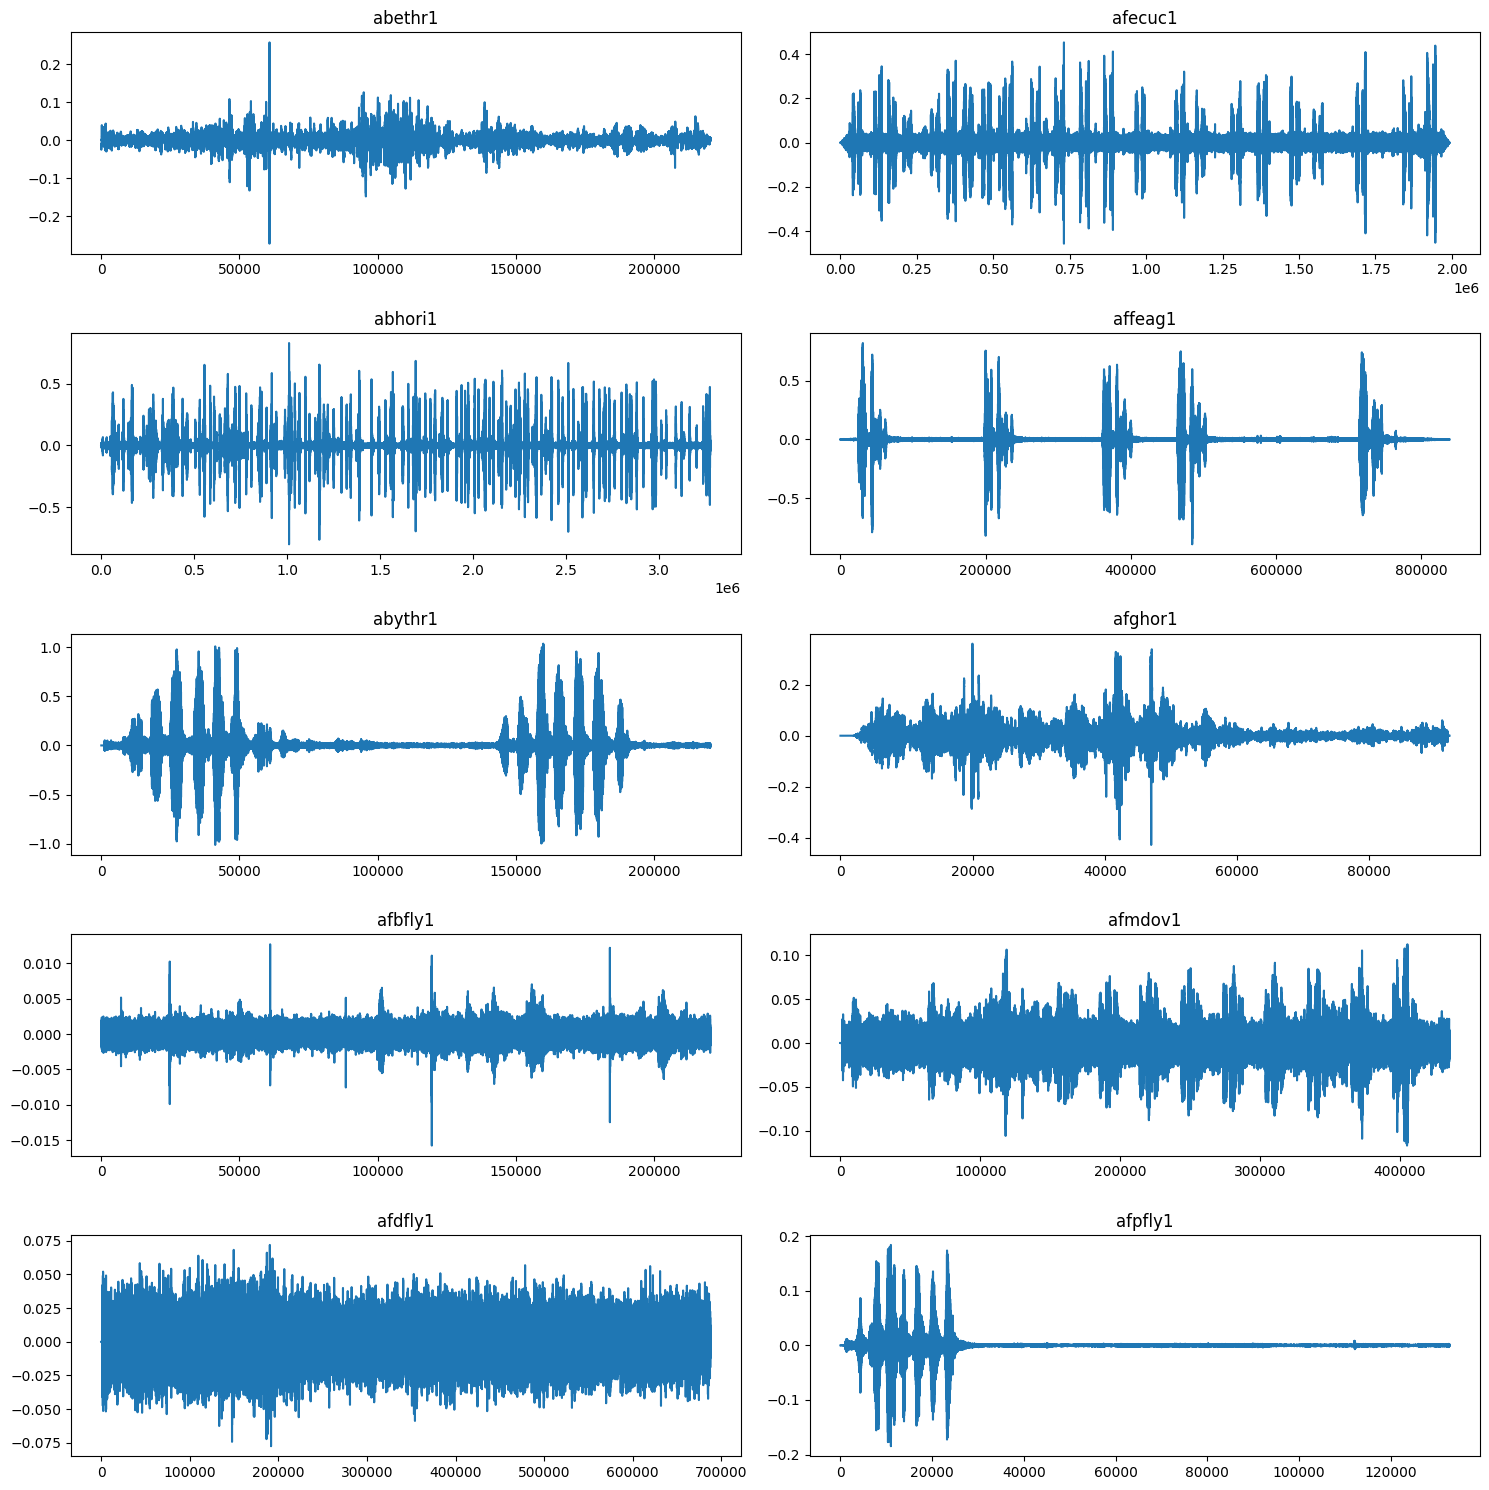

In [17]:
dataset_df = data
random_samples = dataset_df.groupby('label').sample(1)
audio_samples, labels = random_samples['relative_path'].tolist(), random_samples['label'].tolist()

fig, axs = plt.subplots(5, 2, figsize=(15, 15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        axs[row][col].plot(audio_file)
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()
plt.show()

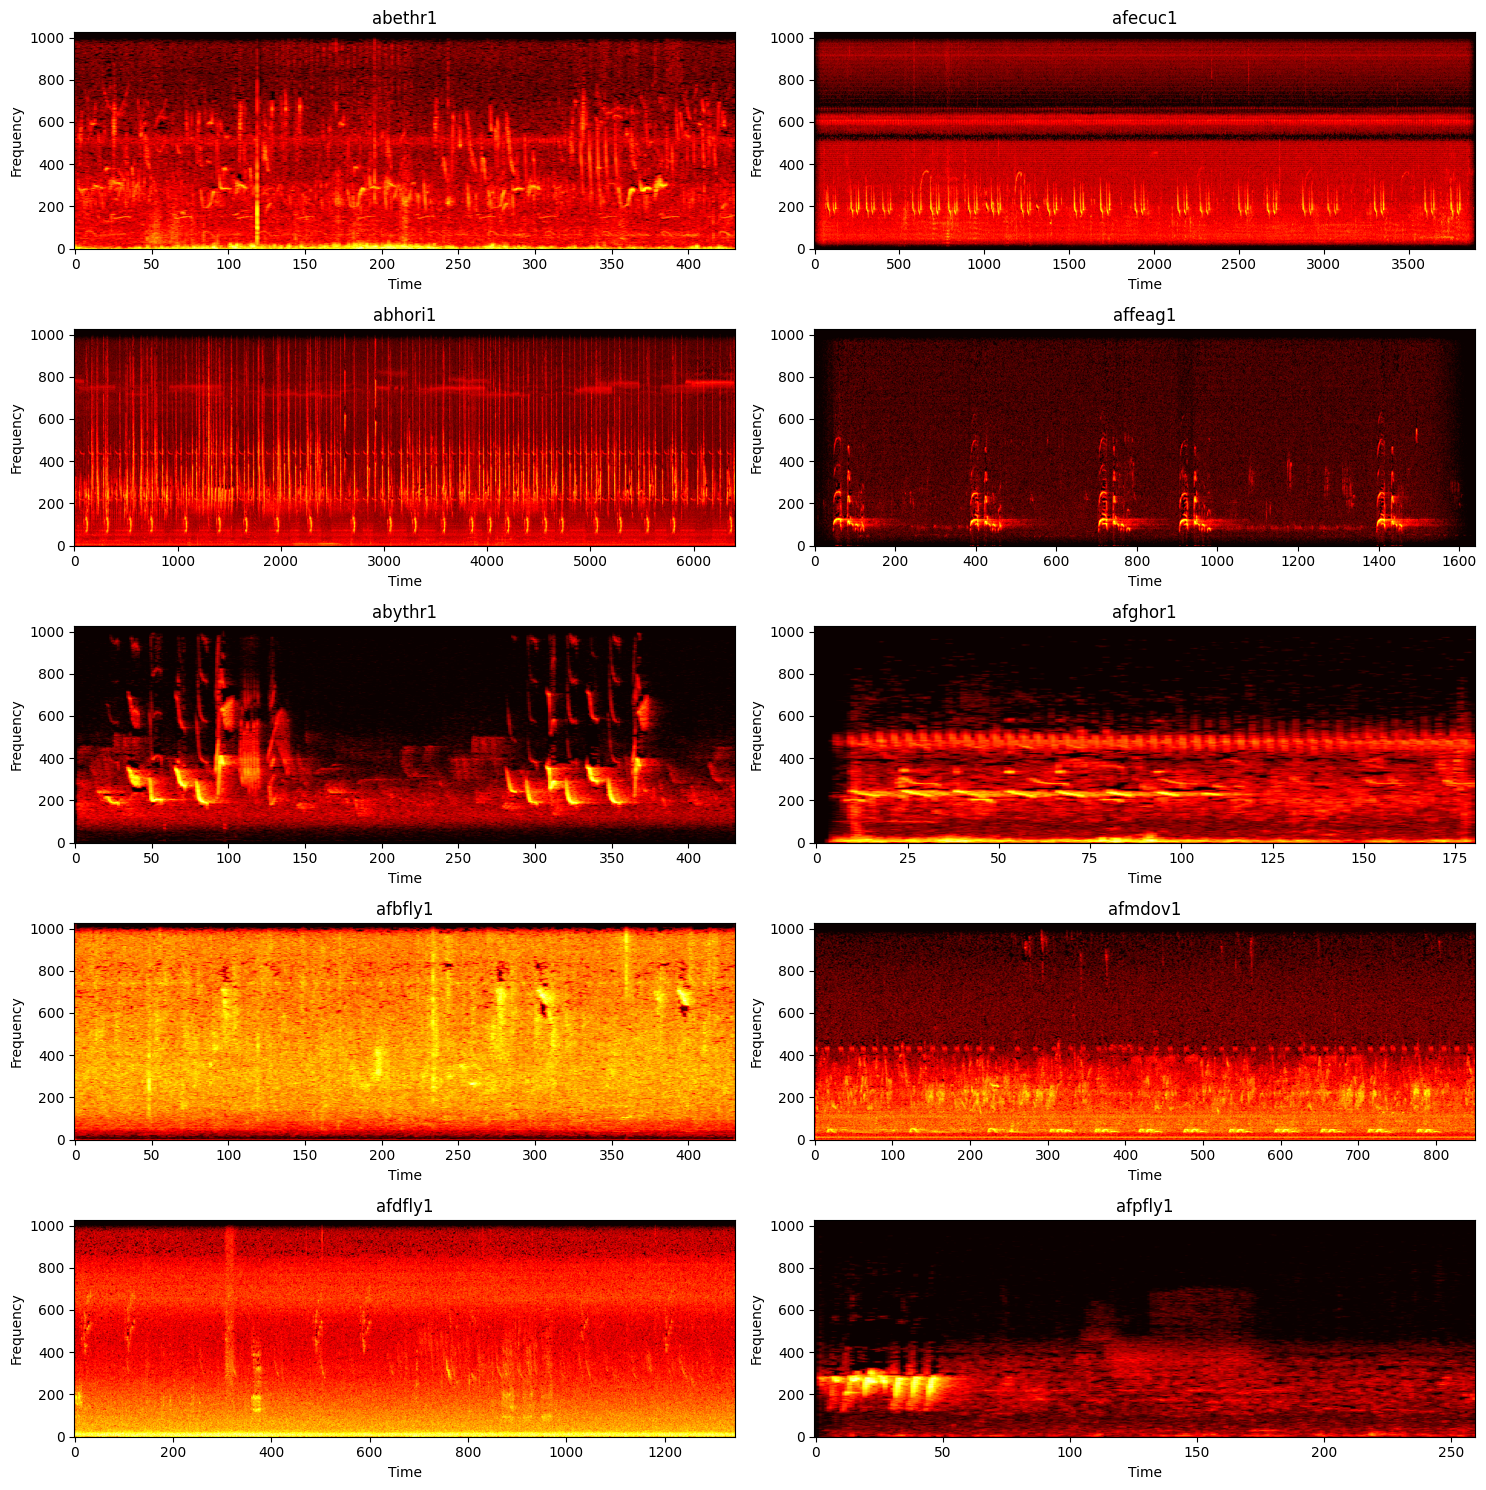

In [44]:
n_fft = 2048
hop_length = 512

fig, axs = plt.subplots(5, 2, figsize=(15, 15))
index = 0

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)
        spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

        axs[row][col].imshow(spectrogram, cmap='hot', origin='lower', aspect='auto')
        axs[row][col].set_title('{}'.format(labels[index]))
        axs[row][col].set_xlabel('Time')
        axs[row][col].set_ylabel('Frequency')
        index += 1

fig.tight_layout()
plt.show()

In [19]:
def collate_fn(batch):
    input_values = torch.stack([item["input_values"] for item in batch])
    labels = torch.tensor([item["labels"] for item in batch])
    return {"input_values": input_values, "labels": labels}

In [20]:
processor = AutoProcessor.from_pretrained(CONFIG['model_name'])

train_dataset = AudioDataset(audio_paths=train_paths, labels=train_labels, processor=processor)
val_dataset = AudioDataset(audio_paths=val_paths, labels=val_labels, processor=processor)
test_dataset = AudioDataset(audio_paths=test_paths, labels=test_labels, processor=processor)

train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=CONFIG['valid_batch_size'], shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], shuffle=False, collate_fn=collate_fn)

In [21]:
class ASTClassifier(nn.Module):
    def __init__(self, model_name="MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=217):
        super(ASTClassifier, self).__init__()
        
        self.model = AutoModelForAudioClassification.from_pretrained(
            model_name,
            num_labels=527,
        )
        
        self.extra_linear = nn.Linear(527, num_labels)

    def forward(self, input_values):
        logits = self.model(input_values).logits
        
        logits = self.extra_linear(logits)
        
        return logits


In [22]:
model = ASTClassifier()
state_dict = torch.load('/kaggle/input/ats_loss_with_wegiths/pytorch/default/3/best_model.pth')
model.load_state_dict(state_dict)
model = model.to(CONFIG['device'])

next(model.model.parameters()).device

/tmp/ipykernel_30/3700218013.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/input/ats_loss_with_wegiths/pytorch/default/3/best_model (3

device(type='cuda', index=0)

In [23]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, evaluate_interval=50):
    model.train()
    total_loss = 0.0
    total_correct = 0
    progress_bar = tqdm(dataloader, desc="Training", unit="batch")

    for batch in progress_bar:
        input_values = batch["input_values"].to(device)
        input_values = input_values.squeeze()
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_values=input_values)
        logits = outputs
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(logits, dim=-1)
        total_correct += (predictions == labels).sum().item()

        total_loss += loss.item() * input_values.size(0)

        progress_bar.set_postfix({"Loss": loss.item()})

    epoch_loss = total_loss / len(dataloader.dataset)
    epoch_acc = total_correct / len(dataloader.dataset)

    return epoch_loss, epoch_acc


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    progress_bar = tqdm(dataloader, desc="Evaluation", unit="batch")

    with torch.no_grad():
        for batch in progress_bar:
            input_values = batch["input_values"].to(device)
            input_values = input_values.squeeze()
            labels = batch["labels"].to(device)

            outputs = model(input_values=input_values)
            logits = outputs
            loss = criterion(logits, labels)
            
            predictions = torch.argmax(logits, dim=-1)
            total_correct += (predictions == labels).sum().item()

            total_loss += loss.item() * input_values.size(0)

            progress_bar.set_postfix({"Loss": loss.item()})

    epoch_loss = total_loss / len(dataloader.dataset)
    epoch_acc = total_correct / len(dataloader.dataset)

    return epoch_loss, epoch_acc


def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device)

        val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    print("Training complete. Best validation accuracy: {:.4f}".format(best_val_acc))


In [24]:
csv_path = "/kaggle/input/birdsounds/birdsounds.csv"
data = pd.read_csv(csv_path)

class_counts = data["id"].value_counts()

total_samples = len(data)
class_weights = total_samples / (len(class_counts) * class_counts)

class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)
class_weights_tensor = class_weights_tensor.to(CONFIG["device"])

In [45]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model.model.parameters(), lr=3e-4)

In [46]:
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, CONFIG["epochs"], CONFIG["device"])

Evaluation: 100%|██████████| 16/16 [02:48<00:00, 10.51s/batch, Loss=1.77]


Epoch [1/1]
  Train Loss: 0.0203 - Train Acc: 0.9864
  Val Loss: 1.8302 - Val Acc: 0.6301
Training complete. Best validation accuracy: 0.6301


In [47]:
def evaluate_test_model(model, test_dataloader, device):

    model.eval()
    all_labels = []
    all_predictions = []

    progress_bar = tqdm(test_dataloader, desc="Testing", unit="batch")
    
    with torch.no_grad():
        for batch in progress_bar:
            input_values = batch["input_values"].to(device).squeeze()
            labels = batch["labels"].to(device)

            outputs = model(input_values=input_values)
            logits = outputs

            predictions = torch.argmax(logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Метрики
    all_labels = torch.tensor(all_labels)
    all_predictions = torch.tensor(all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1_micro = f1_score(all_labels, all_predictions, average="micro")
    f1_macro = f1_score(all_labels, all_predictions, average="macro")

    return accuracy, f1_micro, f1_macro, confusion_matrix(all_labels, all_predictions)

In [48]:
# model_test = ASTClassifier()
# state_dict = torch.load('/kaggle/input/ats_loss_with_wegiths/pytorch/default/1/best_model (1).pth')
# model_test.load_state_dict(state_dict)
# model_test = model_test.to(CONFIG['device'])

In [49]:
class_names = test_dataloader.dataset.class_names if hasattr(test_dataloader.dataset, "class_names") else None

In [50]:
accuracy, f1_micro, f1_macro, cm = evaluate_test_model(model, test_dataloader, CONFIG["device"])

Testing: 100%|██████████| 16/16 [02:50<00:00, 10.66s/batch]


In [51]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Micro: {f1_micro:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")

Test Accuracy: 0.6543
Test F1 Micro: 0.6543
Test F1 Macro: 0.5597


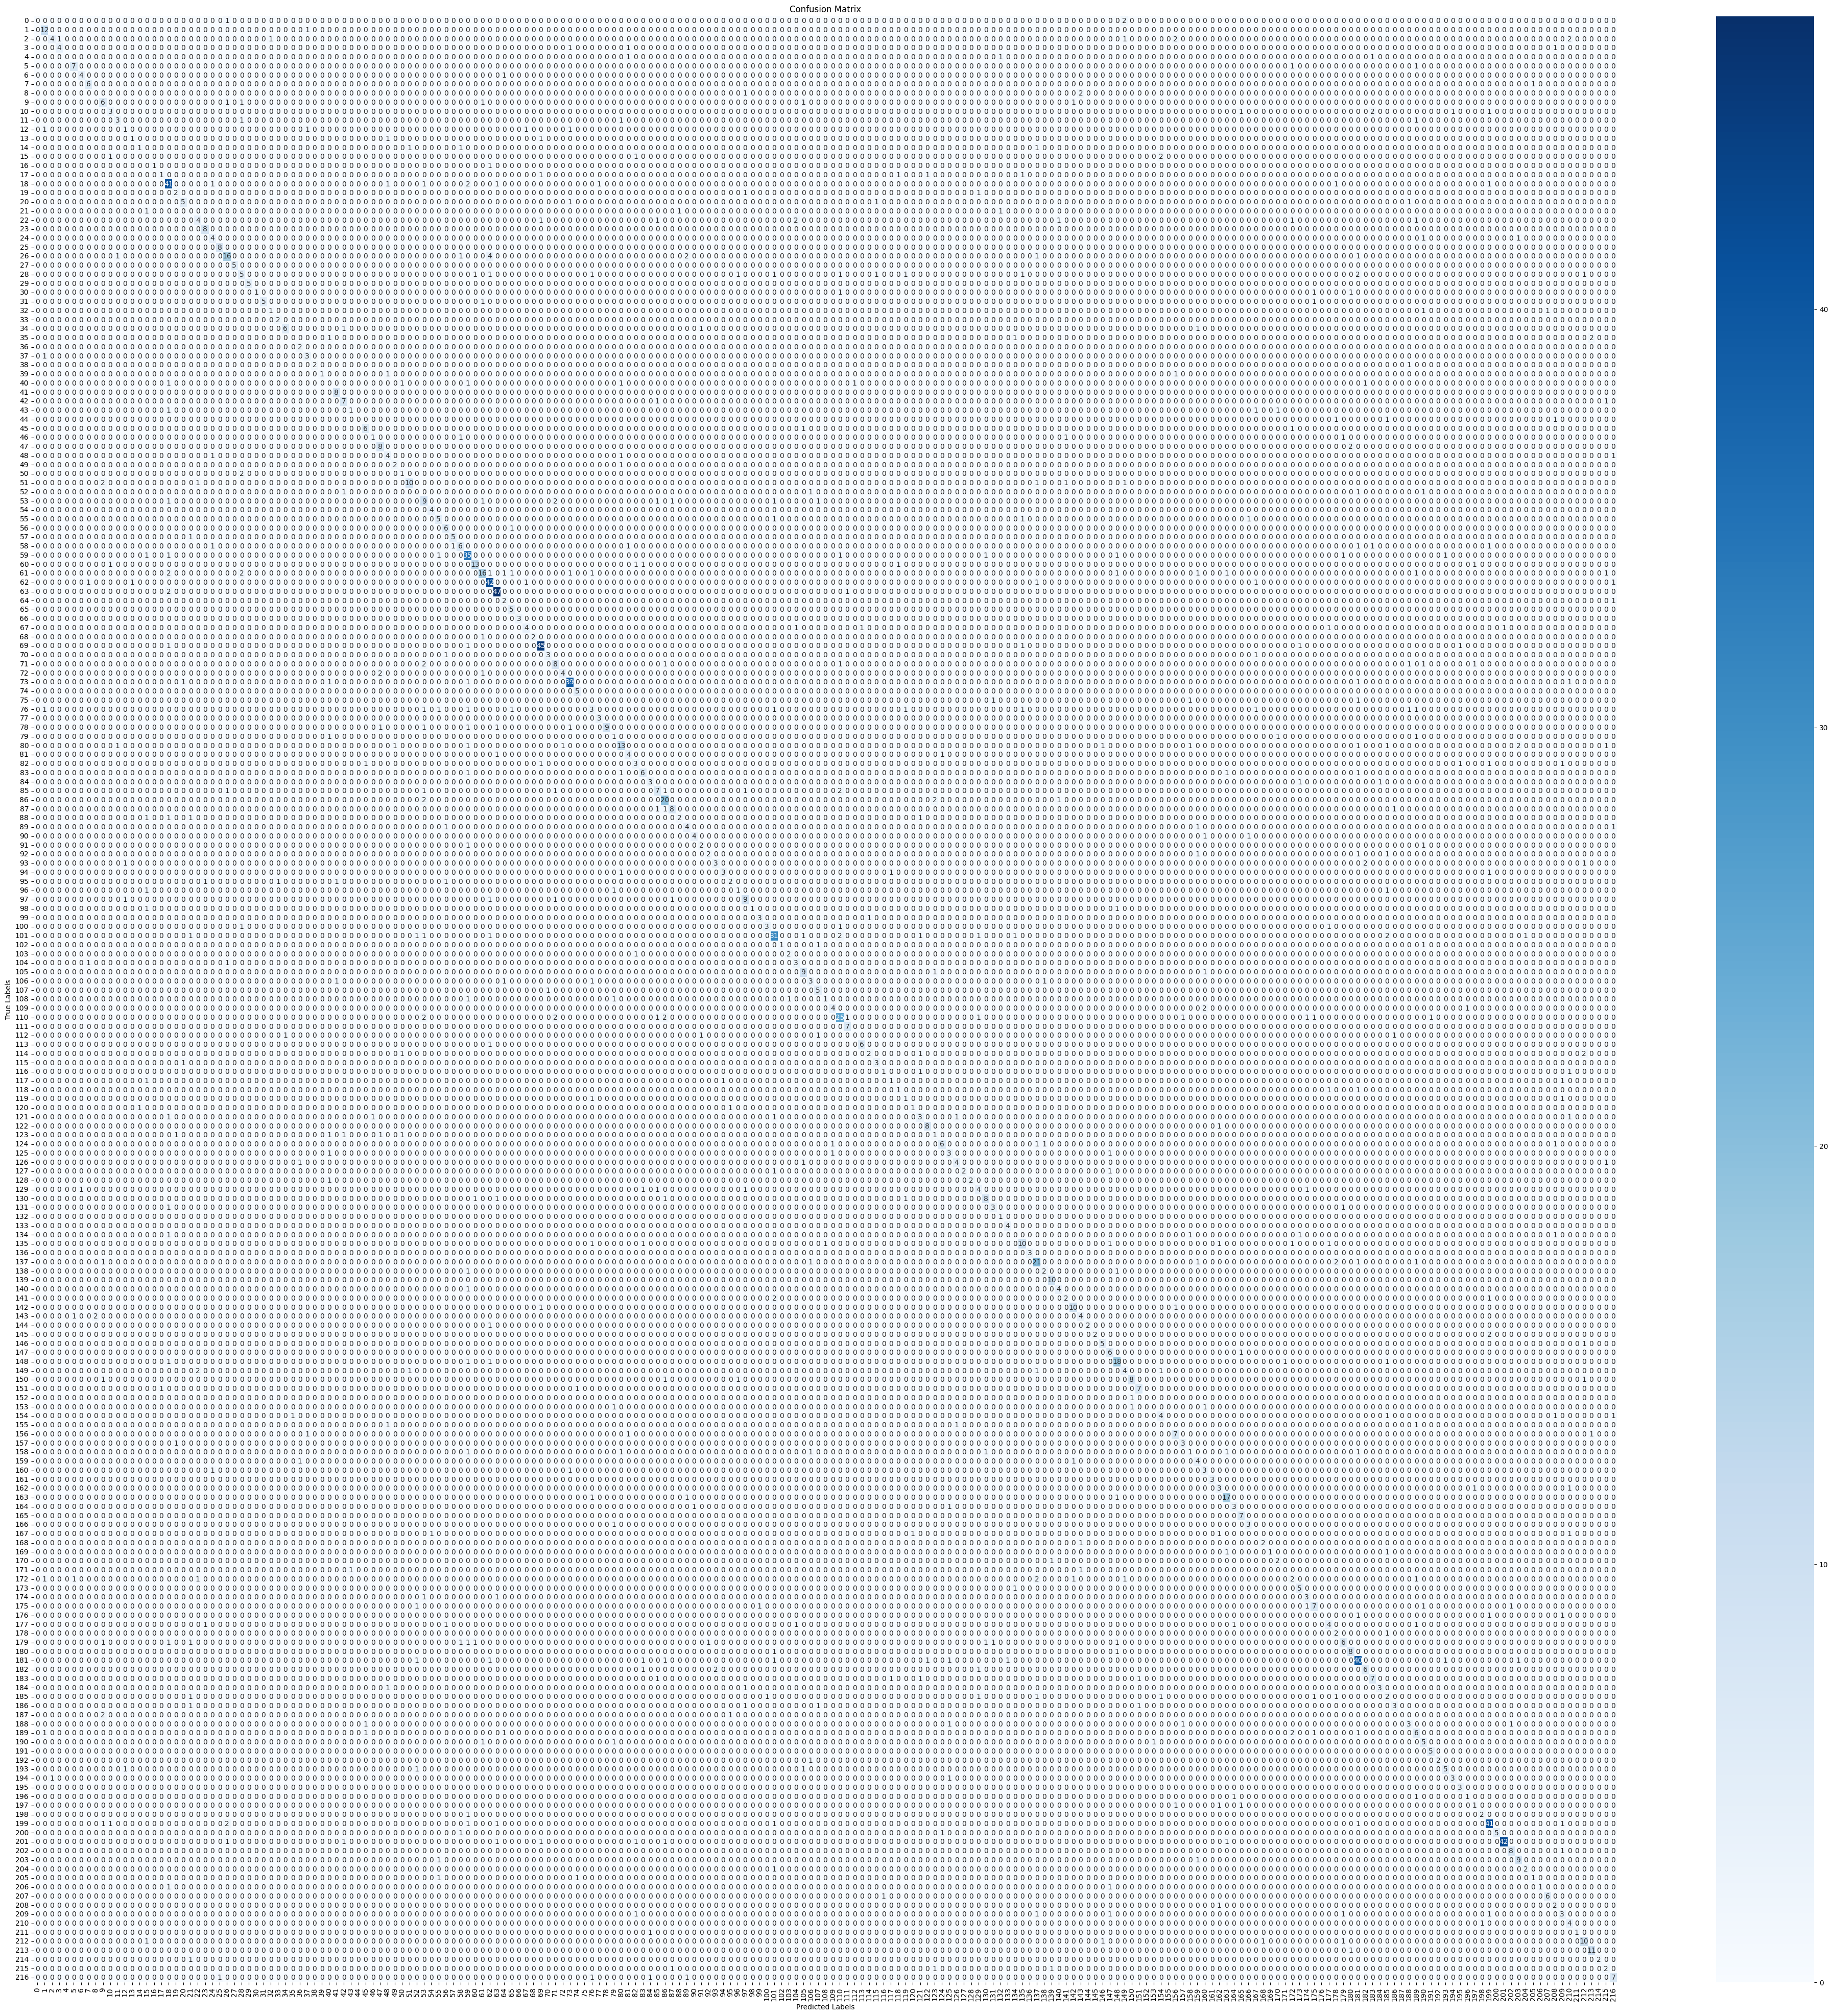

In [52]:
plt.figure(figsize=(50, 50))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names if class_names else range(len(cm)), 
    yticklabels=class_names if class_names else range(len(cm))
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()